Importing libraries

[nltk_data] Downloading package stopwords to C:\Users\Lillian
[nltk_data]     Hurban\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


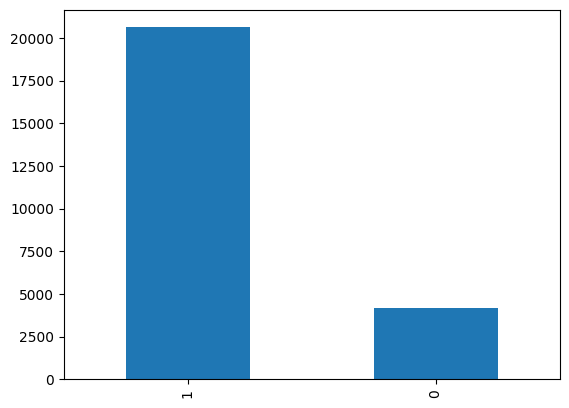

Best parameters for SVM:  {'C': 1}
Best parameters for Naive Bayes:  {'alpha': 0.1}
Best parameters for K-Nearest Neighbors:  {'n_neighbors': 10, 'p': 2}
Best parameters for Random Forest:  {'bootstrap': True, 'n_estimators': 5}


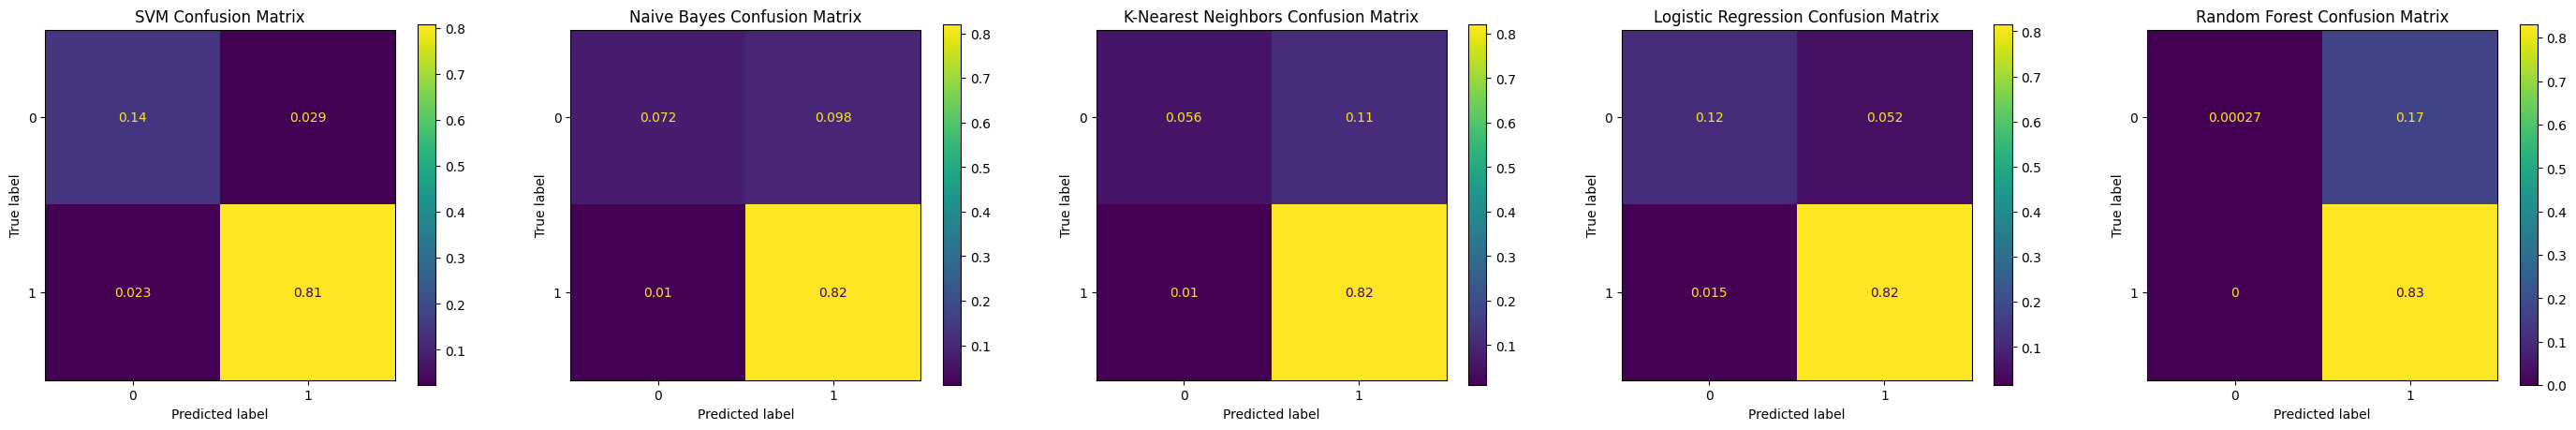

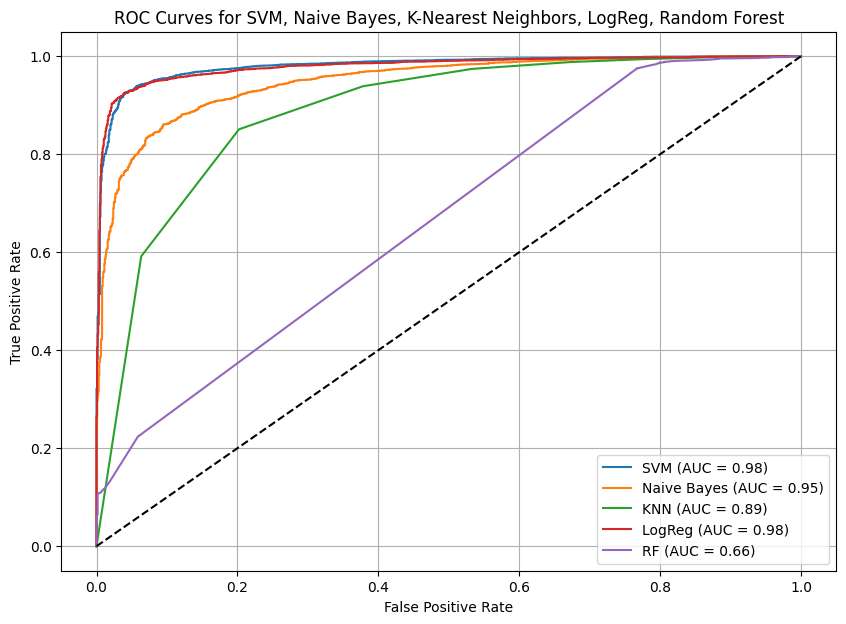

G-Mean Score for SVM:  0.8983473651613427
Cohen-Kappa Score for SVM:  0.8127873608557786
Balanced Accuracy for SVM:  0.9011363429099596 

G-Mean Score for Naive Bayes:  0.6466246432624427
Cohen-Kappa Score for Naive Bayes:  0.5166342803605568
Balanced Accuracy for Naive Bayes:  0.7054199044520947 

G-Mean Score for K-Nearest Neighbors:  0.5695400017036131
Cohen-Kappa Score for K-Nearest Neighbors:  0.4183649833658638
Balanced Accuracy for K-Nearest Neighbors:  0.6581625588568571 

G-Mean Score for Logistic Regression:  0.8244008065502917
Cohen-Kappa Score for Logistic Regression:  0.738045027926997
Balanced Accuracy for Logistic Regression:  0.8370025665944033 

G-Mean Score for Random Forest:  0.03982515314667635
Cohen-Kappa Score for Random Forest:  0.002631331922128388
Balanced Accuracy for Random Forest:  0.5007930214115781


In [71]:
import os
import nltk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
%run my_models.ipynb

Importing data GRACE LOOK HERE

https://github.com/Noman712/contextual-abusive-language-detection/tree/main/dataset/labelled

In [60]:
os.chdir(r"C:\Users\Lillian Hurban\Downloads\STOR 565\final project")
raw1 = pd.read_csv("train_abusive.csv")
raw2 = pd.read_csv("train_nonabusive.csv")
raw3 = pd.read_csv("test_abusive.csv")
raw4 = pd.read_csv("test_nonabusive.csv")

raw1["label"] = 1
raw2["label"] = 0
raw3["label"] = 1
raw4["label"] = 0

YT_comments = pd.concat([raw1, raw2, raw3, raw4], ignore_index = True)

In [62]:
if "comment" in YT_comments.columns:
    YT_comments["comment"] = YT_comments["comment"].apply(lambda x: x.lower())
    YT_comments["comment"] = YT_comments["comment"].apply(clean_tweet)


Cleaning tweets

0    2009
1    1970
Name: label, dtype: int64


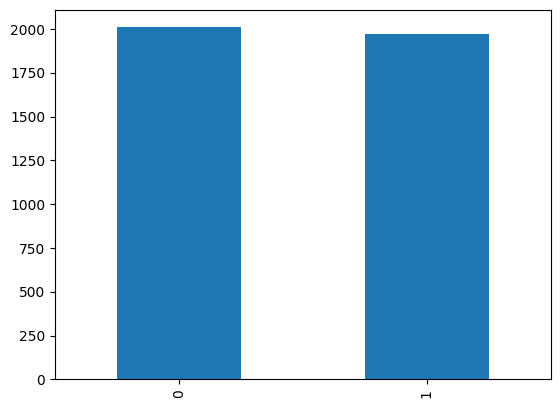

In [63]:
class_labels = YT_comments["label"]
class_counts = class_labels.value_counts()
class_counts.plot.bar()

print(class_counts)

In [64]:
x_train, x_test, y_train, y_test = train_test_split(YT_comments["comment"], 
                                                    YT_comments["label"], 
                                                    test_size = 0.3, 
                                                    random_state = 0)

tfidf = TfidfVectorizer()
tfidf_xtrain = tfidf.fit_transform(x_train)
tfidf_xtest = tfidf.transform(x_test)

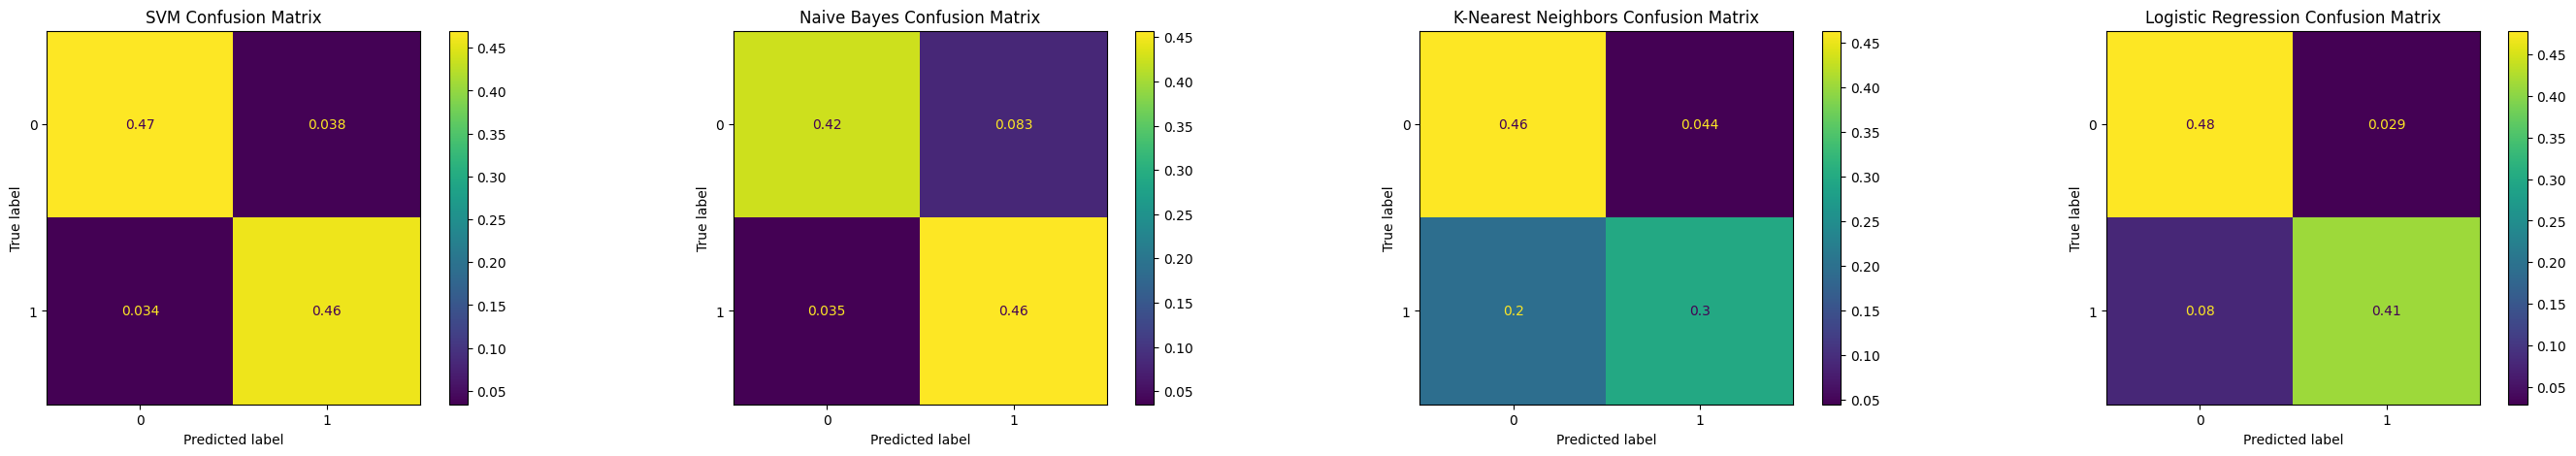

In [67]:
svm = LinearSVC(dual = False, C = 1)
nb = MultinomialNB(alpha = 0.1)
knn = KNeighborsClassifier(n_neighbors = 10, p = 2)
log = LogisticRegression()


svm_ideal = svm.fit(tfidf_xtrain, y_train)
nb_ideal = nb.fit(tfidf_xtrain, y_train)
knn_ideal = knn.fit(tfidf_xtrain, y_train)
log_ideal = log.fit(tfidf_xtrain, y_train)


svm_pred = svm_ideal.predict(tfidf_xtest)
nb_pred = nb_ideal.predict(tfidf_xtest)
knn_pred = knn_ideal.predict(tfidf_xtest)
log_pred = log_ideal.predict(tfidf_xtest)

confusion_svm = confusion_matrix(y_test, svm_pred, labels = svm_ideal.classes_)
confusion_nb = confusion_matrix(y_test, nb_pred, labels = nb_ideal.classes_)
confusion_knn = confusion_matrix(y_test, knn_pred, labels = knn_ideal.classes_)
confusion_log = confusion_matrix(y_test, log_pred, labels = log_ideal.classes_)

total_samples = np.sum(confusion_svm)

consvm = confusion_svm / total_samples
connb = confusion_nb / total_samples
conknn = confusion_knn / total_samples
conlog = confusion_log / total_samples


fig, axes = plt.subplots(1, 4, figsize = (35, 5))

svm_CM_plot = ConfusionMatrixDisplay(confusion_matrix = consvm, display_labels = svm_ideal.classes_)
svm_CM_plot.plot(ax=axes[0])
axes[0].set_title("SVM Confusion Matrix")

nb_CM_plot = ConfusionMatrixDisplay(confusion_matrix = connb, display_labels = nb_ideal.classes_)
nb_CM_plot.plot(ax=axes[1])
axes[1].set_title("Naive Bayes Confusion Matrix")

knn_CM_plot = ConfusionMatrixDisplay(confusion_matrix = conknn, display_labels = knn_ideal.classes_)
knn_CM_plot.plot(ax=axes[2])
axes[2].set_title("K-Nearest Neighbors Confusion Matrix")

log_CM_plot = ConfusionMatrixDisplay(confusion_matrix = conlog, display_labels = log_ideal.classes_)
log_CM_plot.plot(ax=axes[3])
axes[3].set_title("Logistic Regression Confusion Matrix")


plt.show()

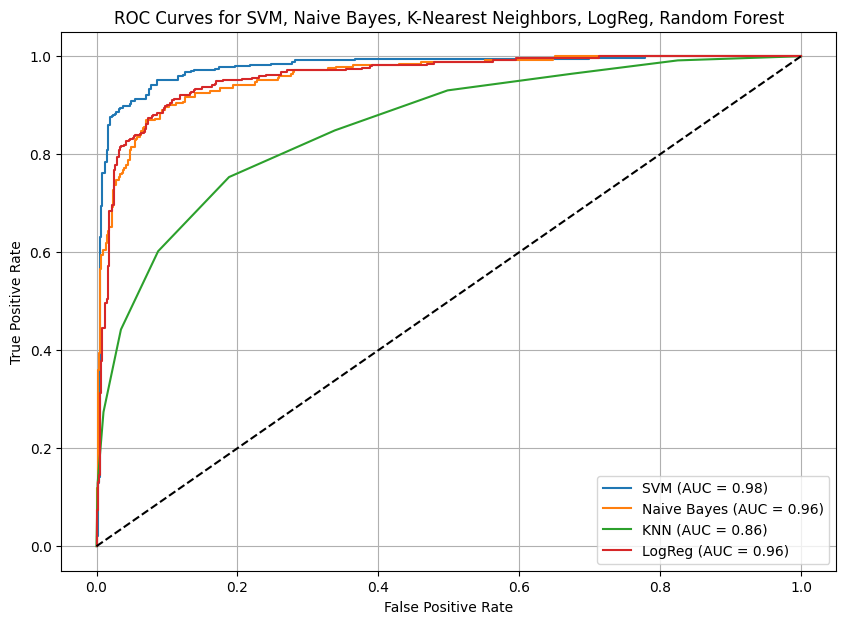

In [68]:
svm_pred_proba = svm_ideal.decision_function(tfidf_xtest)
nb_pred_proba = nb_ideal.predict_proba(tfidf_xtest)[:, 1] 
knn_pred_proba = knn_ideal.predict_proba(tfidf_xtest)[:, 1]  
log_pred_proba = log_ideal.predict_proba(tfidf_xtest)[:, 1]

# svm
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_pred_proba)
roc_auc_svm = roc_auc_score(y_test, svm_pred_proba)

# naive bayes
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb_pred_proba)
roc_auc_nb = roc_auc_score(y_test, nb_pred_proba)

# knn
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, knn_pred_proba)
roc_auc_knn = roc_auc_score(y_test, knn_pred_proba)

# logreg
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, log_pred_proba)
roc_auc_log = roc_auc_score(y_test, log_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr_svm, tpr_svm, label = f"SVM (AUC = {roc_auc_svm:.2f})")
plt.plot(fpr_nb, tpr_nb, label = f"Naive Bayes (AUC = {roc_auc_nb:.2f})")
plt.plot(fpr_knn, tpr_knn, label = f"KNN (AUC = {roc_auc_knn:.2f})")
plt.plot(fpr_log, tpr_log, label = f"LogReg (AUC = {roc_auc_log:.2f})")


# line that indicates random guessing
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for SVM, Naive Bayes, K-Nearest Neighbors, LogReg, Random Forest")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
print("G-Mean Score for SVM: ", geometric_mean_score(y_test, svm_pred))
print("Cohen-Kappa Score for SVM: ", cohen_kappa_score(y_test, svm_pred)) 
print("Balanced Accuracy for SVM: ", balanced_accuracy_score(y_test, svm_pred), "\n")

print("G-Mean Score for Naive Bayes: ", geometric_mean_score(y_test, nb_pred))
print("Cohen-Kappa Score for Naive Bayes: ", cohen_kappa_score(y_test, nb_pred)) 
print("Balanced Accuracy for Naive Bayes: ", balanced_accuracy_score(y_test, nb_pred), "\n")

print("G-Mean Score for K-Nearest Neighbors: ", geometric_mean_score(y_test, knn_pred))
print("Cohen-Kappa Score for K-Nearest Neighbors: ", cohen_kappa_score(y_test, knn_pred)) 
print("Balanced Accuracy for K-Nearest Neighbors: ", balanced_accuracy_score(y_test, knn_pred), "\n")

print("G-Mean Score for Logistic Regression: ", geometric_mean_score(y_test, log_pred))
print("Cohen-Kappa Score for Logistic Regression: ", cohen_kappa_score(y_test, log_pred)) 
print("Balanced Accuracy for Logistic Regression: ", balanced_accuracy_score(y_test, log_pred), "\n")


G-Mean Score for SVM:  0.9280045780063267
Cohen-Kappa Score for SVM:  0.8559282082365223
Balanced Accuracy for SVM:  0.9280073415504816 

G-Mean Score for Naive Bayes:  0.88140462670843
Cohen-Kappa Score for Naive Bayes:  0.7641050215642261
Balanced Accuracy for Naive Bayes:  0.8826025459688827 

G-Mean Score for K-Nearest Neighbors:  0.741206503995546
Cohen-Kappa Score for K-Nearest Neighbors:  0.5169453536660662
Balanced Accuracy for K-Nearest Neighbors:  0.7572910352259716 

G-Mean Score for Logistic Regression:  0.8888255671637638
Cohen-Kappa Score for Logistic Regression:  0.7818644810954838
Balanced Accuracy for Logistic Regression:  0.8903397992860511 



In [72]:
#Helper function to print metrics
def print_model_metrics(model_name, predictions, y_test):

    # Calculate metrics
    report = classification_report(y_test, predictions, output_dict=True)
    confusion = confusion_matrix(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    total_samples = np.sum(confusion)
    normalized_confusion = confusion / total_samples

    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.applymap(lambda x: f'{x:.4f}' if isinstance(x, float) else x)

    # Styling
    styled_df = report_df.style.set_properties(**{'background-color': 'lightblue',
                                                 'color': 'black',
                                                 'border-color': 'black',
                                                 'border-style': 'solid',
                                                 'border-width': '1px'})

    def highlight_metrics(row):
      if row.name == '1':
          return ['background-color: yellow']*len(row)
      else:
          return ['background-color: lightblue']*len(row)

    styled_df = styled_df.apply(highlight_metrics, axis=1)

    styled_df.set_table_styles([{'selector': 'th',
                                 'props': [('background-color', '#4f6379'),
                                           ('color', 'white'),
                                           ('border-color', 'black'),
                                           ('border-style', 'solid'),
                                           ('border-width', '1px')]}])

    styled_df.set_caption(f"<b>{model_name}</b>")

    display(styled_df)

# Example usage
print_model_metrics("SVM", svm_pred, y_test)
print_model_metrics("Naive Bayes", nb_pred, y_test)
print_model_metrics("KNN", knn_pred, y_test)
print_model_metrics("Logistic Regression", log_pred, y_test)

,precision,recall,f1-score,support
0,0.8582,0.8303,0.8440,1261.0000
1,0.9656,0.9720,0.9688,6174.0000
accuracy,0.9479,0.9479,0.9479,0.9479
macro avg,0.9119,0.9011,0.9064,7435.0000
weighted avg,0.9474,0.9479,0.9476,7435.0000


,precision,recall,f1-score,support
0,0.8725,0.4235,0.5702,1261.0000
1,0.8934,0.9874,0.9381,6174.0000
accuracy,0.8917,0.8917,0.8917,0.8917
macro avg,0.8830,0.7054,0.7541,7435.0000
weighted avg,0.8899,0.8917,0.8757,7435.0000


,precision,recall,f1-score,support
0,0.8484,0.3283,0.4734,1261.0000
1,0.8781,0.9880,0.9298,6174.0000
accuracy,0.8761,0.8761,0.8761,0.8761
macro avg,0.8632,0.6582,0.7016,7435.0000
weighted avg,0.8730,0.8761,0.8524,7435.0000


,precision,recall,f1-score,support
0,0.8854,0.6923,0.7770,1261.0000
1,0.9398,0.9817,0.9603,6174.0000
accuracy,0.9326,0.9326,0.9326,0.9326
macro avg,0.9126,0.8370,0.8687,7435.0000
weighted avg,0.9306,0.9326,0.9292,7435.0000


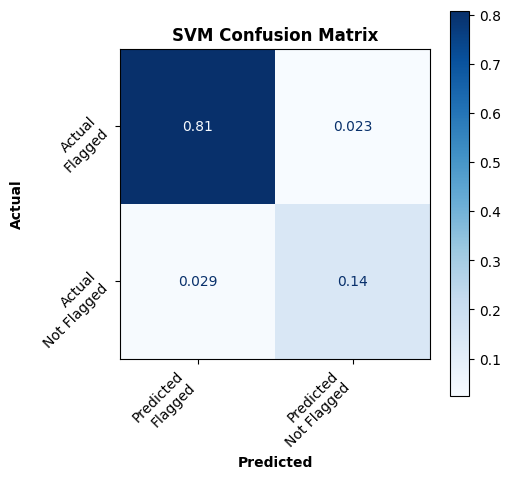

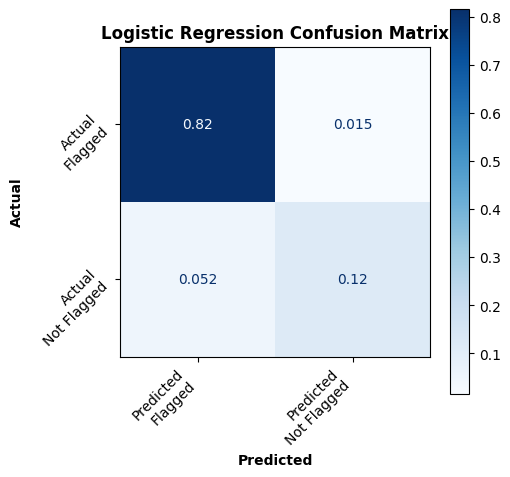

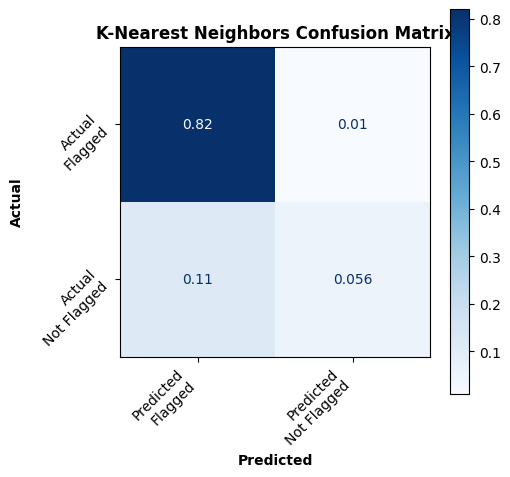

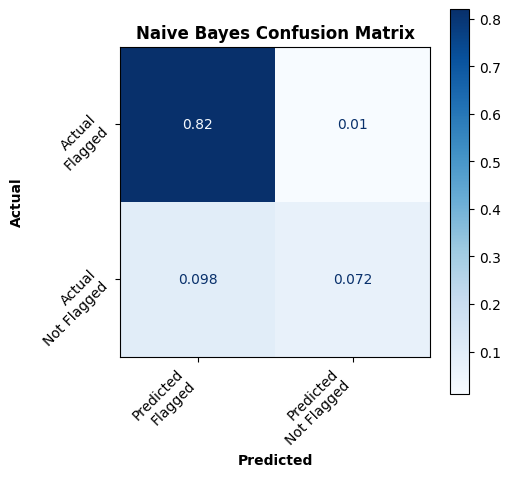

In [75]:
#Helper function to print confusion matrix
def print_confusion_matrix(conf_matrix, model_name):

    # Invert the confusion matrix order
    conf_matrix_inverted = conf_matrix[::-1, ::-1]

    # Create a matplotlib figure and axes
    fig, ax = plt.subplots(figsize=(5, 5))

    # Plot the confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix_inverted, display_labels=['Not Flagged', 'Flagged']).plot(cmap="Blues", ax=ax)

    # Set labels and tick labels
    ax.set_xlabel('Predicted', fontweight='bold')
    ax.set_ylabel('Actual', fontweight='bold')
    ax.set_xticklabels(['Predicted\nFlagged', 'Predicted\nNot Flagged'], rotation=45, ha="right")
    ax.set_yticklabels(['Actual\nFlagged', 'Actual\nNot Flagged'], rotation=45, ha="right")
    ax.set_title(f"{model_name} Confusion Matrix", fontweight='bold')

#Example usage
print_confusion_matrix(consvm, "SVM")
print_confusion_matrix(conlog, "Logistic Regression")
print_confusion_matrix(conknn, "K-Nearest Neighbors")
print_confusion_matrix(connb, "Naive Bayes")

In [77]:
svm_recall = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[1, 0])), 4)
svm_precision = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[0, 1])), 4)
svm_accuracy = round(((confusion_svm[0, 0] + confusion_svm[1, 1]) / total_samples), 4)
svm_f1 = round((2 * svm_recall * svm_precision) / (svm_recall + svm_precision), 4)

nb_recall = round((confusion_nb[1, 1] / (confusion_nb[1, 1] + confusion_nb[1, 0])), 4)
nb_precision = round((confusion_nb[1, 1] / (confusion_nb[1, 1] + confusion_nb[0, 1])), 4)
nb_accuracy = round(((confusion_nb[0, 0] + confusion_nb[1, 1]) / total_samples), 4)
nb_f1 = round((2 * nb_recall * nb_precision) / (nb_recall + nb_precision), 4)

knn_recall = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[1, 0])), 4)
knn_precision = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[0, 1])), 4)
knn_accuracy = round(((confusion_knn[0, 0] + confusion_knn[1, 1]) / total_samples), 4)
knn_f1 = round((2 * knn_recall * knn_precision) / (knn_recall + knn_precision), 4)

lr_recall = round((confusion_log[1, 1] / (confusion_log[1, 1] + confusion_log[1, 0])), 4)
lr_precision = round((confusion_log[1, 1] / (confusion_log[1, 1] + confusion_log[0, 1])), 4)
lr_accuracy = round(((confusion_log[0, 0] + confusion_log[1, 1]) / total_samples), 4)
lr_f1 = round((2 * lr_recall * lr_precision) / (lr_recall + lr_precision), 4)

data = {
    'Model': ['SVM', 'Naive Bayes', 'KNN', 'Logistic Regression'],
    'Recall': [svm_recall, nb_recall, knn_recall, lr_recall],
    'Precision': [svm_precision, nb_precision, knn_precision, lr_precision],
    'Accuracy': [svm_accuracy, nb_accuracy, knn_accuracy, lr_accuracy],
    'F1 Score': [svm_f1, nb_f1, knn_f1, lr_f1]
}

df = pd.DataFrame(data)
df = df.applymap(lambda x: f'{x:g}' if isinstance(x, float) else x)

styled_df = df.style.set_properties(**{'background-color': 'lightblue',
                                       'color': 'black',
                                       'border-color': 'black',
                                       'border-style': 'solid',
                                       'border-width': '1px'})

styled_df.set_table_styles([{'selector': 'th',
                             'props': [('background-color', '#4f6379'),
                                       ('color', 'white'),
                                       ('border-color', 'black'),
                                       ('border-style', 'solid'),
                                       ('border-width', '1px')]}])

styled_df.set_caption("<b>TF-IDF Vectorizer: Model Metrics</b>")

,Model,Recall,Precision,Accuracy,F1 Score
0,SVM,0.972,0.9656,0.9479,0.9688
1,Naive Bayes,0.9874,0.8934,0.8917,0.9381
2,KNN,0.988,0.8781,0.8761,0.9298
3,Logistic Regression,0.9817,0.9398,0.9326,0.9603


In [79]:
# Calculate metrics for SVM
svm_recall = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[1, 0])), 4)
svm_precision = round((confusion_svm[1, 1] / (confusion_svm[1, 1] + confusion_svm[0, 1])), 4)
svm_accuracy = round(((confusion_svm[0, 0] + confusion_svm[1, 1]) / total_samples), 4)
svm_f1 = round((2 * svm_recall * svm_precision) / (svm_recall + svm_precision), 4)

# Calculate metrics for KNN
knn_recall = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[1, 0])), 4)
knn_precision = round((confusion_knn[1, 1] / (confusion_knn[1, 1] + confusion_knn[0, 1])), 4)
knn_accuracy = round(((confusion_knn[0, 0] + confusion_knn[1, 1]) / total_samples), 4)
knn_f1 = round((2 * knn_recall * knn_precision) / (knn_recall + knn_precision), 4)

# Calculate metrics for Logistic Regression
lr_recall = round((confusion_log[1, 1] / (confusion_log[1, 1] + confusion_log[1, 0])), 4)
lr_precision = round((confusion_log[1, 1] / (confusion_log[1, 1] + confusion_log[0, 1])), 4)
lr_accuracy = round(((confusion_log[0, 0] + confusion_log[1, 1]) / total_samples), 4)
lr_f1 = round((2 * lr_recall * lr_precision) / (lr_recall + lr_precision), 4)

# Create a DataFrame
data = {
    'Model': ['SVM', 'KNN', 'Logistic Regression'],
    'Recall': [svm_recall, knn_recall, lr_recall],
    'Precision': [svm_precision, knn_precision, lr_precision],
    'Accuracy': [svm_accuracy, knn_accuracy, lr_accuracy],
    'F1 Score': [svm_f1, knn_f1, lr_f1]
}

df2 = pd.DataFrame(data)

df2 = df2.applymap(lambda x: f'{x:g}' if isinstance(x, float) else x)

# Styling the DataFrame
styled_df2 = df2.style.set_properties(**{'background-color': 'lightblue',
                                       'color': 'black',
                                       'border-color': 'black',
                                       'border-style': 'solid',
                                       'border-width': '1px'})

styled_df2.set_table_styles([{'selector': 'th',
                             'props': [('background-color', '#4f6379'),
                                       ('color', 'white'),
                                       ('border-color', 'black'),
                                       ('border-style', 'solid'),
                                       ('border-width', '1px')]}])

styled_df2.set_caption("<b>TF-IDF Vectorizer & Word2Vec Combined: Model Metrics</b>")


,Model,Recall,Precision,Accuracy,F1 Score
0,SVM,0.972,0.9656,0.9479,0.9688
1,KNN,0.988,0.8781,0.8761,0.9298
2,Logistic Regression,0.9817,0.9398,0.9326,0.9603
